# Метрики для Яндекс.Афиши.

# Описание проекта

Необходимо помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Яндекс.Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов.
Необходимо изучить:
как клиенты пользуются сервисом,
когда делают первые покупки на сайте,
сколько денег приносит компании каждый клиент,
когда расходы на привлечение клиента окупаются.
Выручка измеряется в условных единицах — у.е.

# Описание данных

Файл visits_log.csv хранит лог сервера с информацией о посещениях сайта, orders_log.csv — информацию о заказах, а costs.csv — информацию о расходах на маркетинг.
Структура visits_log.csv
Uid — уникальный идентификатор пользователя,
Device — категория устройства пользователя,
Start Ts — дата и время начала сессии,
End Ts — дата и время окончания сессии,
Source Id — идентификатор источника перехода на сайт.
Структура orders_log.csv
Uid — уникальный идентификатор пользователя,
Buy Ts — дата и время заказа,
Revenue — сумма заказа.
Структура costs.csv
source_id — идентификатор рекламного источника,
dt — дата проведения рекламной кампании,
costs — расходы на эту кампанию.

## Загрузка данных и их подготовка к анализу

### Запись таблиц в переменные

In [1]:
# импортируем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

from pandas.plotting import register_matplotlib_converters
pd.plotting.register_matplotlib_converters()

from IPython.display import display
from scipy import stats as st

In [2]:
# читаем файл
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
# выводим таблицу
display(visits)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [4]:
# выводим таблицу
display(orders)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [5]:
# выводим таблицу
display(costs)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


### Подготовка данных

In [6]:
# смотрим инфу о таблице с визитами, проверяя на нули и соответствие типов
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [7]:
# переименуем колонки
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [8]:
# изменим тип данных для колонок со временем
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [9]:
# посмотрим инфо о табличке orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [10]:
# переименуем колонки
orders.columns = ['buy_ts', 'revenue', 'uid']

In [11]:
# приведем колонку со временем покупки к корректному типу
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [12]:
# посмотрим инфо о расходах
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [13]:
# изменим тип данных для времени
costs['dt'] = pd.to_datetime(costs['dt'])

In [14]:
# посмотрим дубли
visits.duplicated().sum()

0

In [15]:
# посмотрим дубли
orders.duplicated().sum()

0

In [16]:
# посмотрим дубли
costs.duplicated().sum()

0

In [17]:
# посмотрим, с чего больше заходили - с десктопных версий или мобильных платформ
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

In [18]:
# посмотрим частоту переходов из раных источников
visits['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

In [19]:
# посмотрим диапазоны дат
print(visits['start_ts'].min())
print(visits['start_ts'].max())

2017-06-01 00:01:00
2018-05-31 23:59:00


In [20]:
# посмотрим диапазоны дат
print(visits['end_ts'].min())
print(visits['end_ts'].max())

2017-06-01 00:02:00
2018-06-01 01:26:00


In [21]:
# посмотрим диапазоны дат
print(orders['buy_ts'].min())
print(orders['buy_ts'].max())

2017-06-01 00:10:00
2018-06-01 00:02:00


## Метрики и графики

### Продуктовые метрики

#### WAU, DAU, MAU

In [22]:
# получим из времени начала сессии день, неделю, месяц и год
visits['session_year']  = visits['start_ts'].dt.year
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
visits['session_month'] = visits['start_ts'].dt.strftime('%Y-%m')

In [23]:
# сгруппируем таблицу с визитами по нужным параметрам даты
# и уникальным юидам
dau = visits.groupby('session_date').agg({'uid': 'nunique'})

wau = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).reset_index()
wau['year_week'] = wau['session_year'].astype('str') + '' + wau['session_week'].astype('str')

mau = visits.groupby('session_month').agg({'uid': 'nunique'}).reset_index()

In [24]:
# рассчитаем dau
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()

# рассчитаем wau
wau_total = (
    visits.groupby(['session_year', 'session_week'])
    .agg({'uid': 'nunique'})
    .mean()
)

# и mau тоже рассчитаем
mau_total = (
    visits.groupby('session_month')
    .agg({'uid': 'nunique'})
    .mean()
)

In [25]:
print(int(dau_total))
print(int(wau_total))
print(int(mau_total))

907
5716
23228


Количество уникальных пользователей в день — 907, в неделю — 5716, в месяц — 23228.

Text(0, 0.5, 'Количество уникальных посетителей')

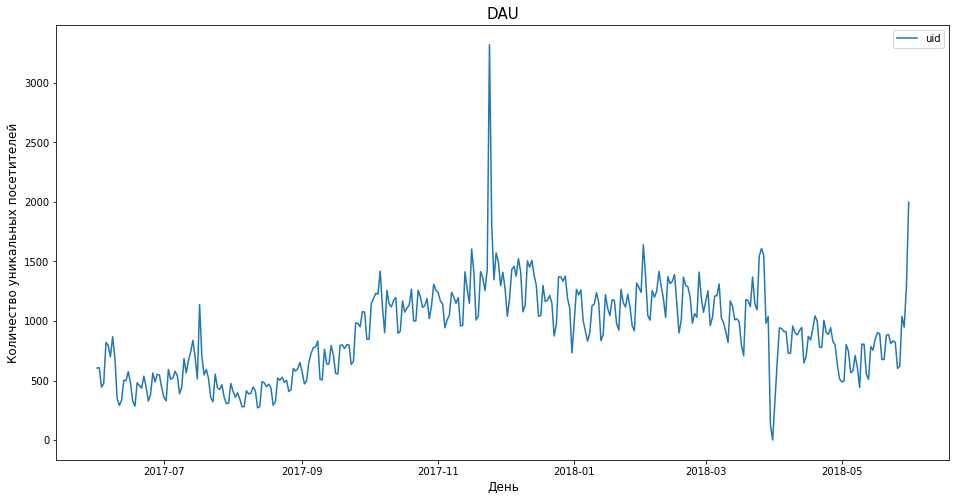

In [26]:
# отрисуем лайнплот для отображения DAU
plt.figure(figsize = (16, 8))
sns.lineplot(data = dau)
plt.title('DAU', fontsize=15)
plt.xlabel('День', fontsize=12)
plt.ylabel('Количество уникальных посетителей', fontsize=12)

In [27]:
df_min = dau.loc[dau['uid'].idxmin()]
df_min

uid    1
Name: 2018-03-31, dtype: int64

In [28]:
df_max = dau.loc[dau['uid'].idxmax()]
df_max

uid    3319
Name: 2017-11-24, dtype: int64

Text(0, 0.5, 'Количество уникальных посетителей')

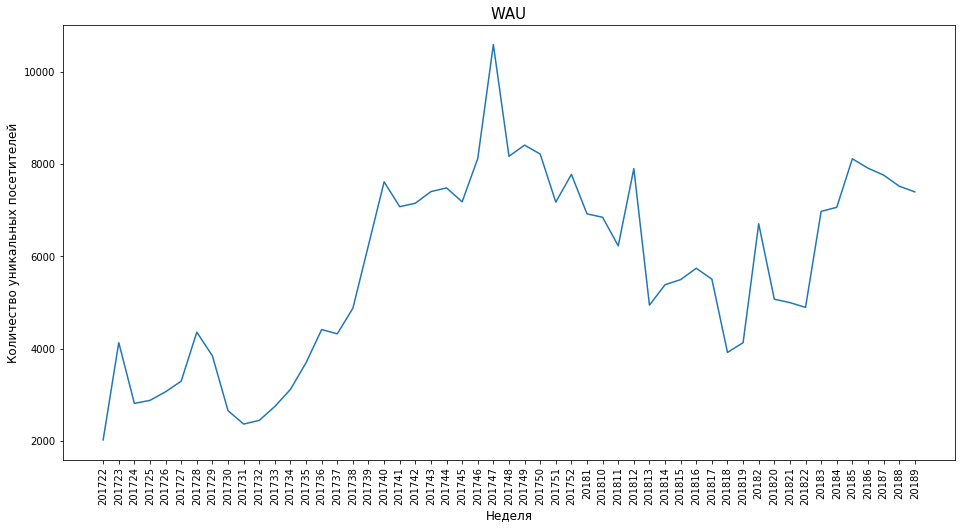

In [29]:
# отрисуем лайнплот для отображения WAU
plt.figure(figsize = (16, 8))
sns.lineplot(data = wau, x = 'year_week', y = 'uid')
plt.title('WAU', fontsize=15)
plt.xticks(rotation='vertical')
plt.xlabel('Неделя', fontsize=12)
plt.ylabel('Количество уникальных посетителей', fontsize=12)

Text(0, 0.5, 'Количество уникальных посетителей')

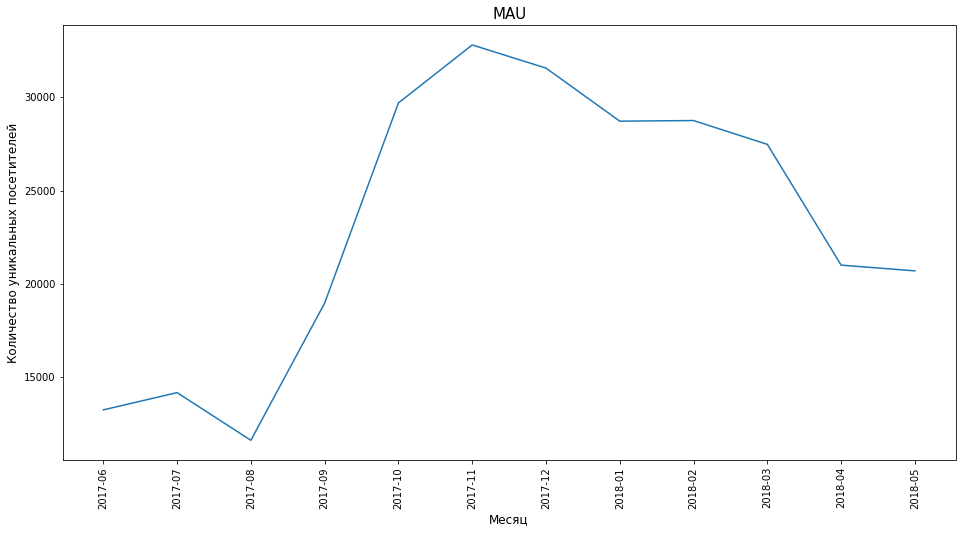

In [30]:
# отрисуем лайнплот для отображения MAU
plt.figure(figsize = (16, 8))
sns.lineplot(data = mau, x = 'session_month', y = 'uid')
plt.xticks(rotation='vertical')
plt.title('MAU', fontsize=15)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество уникальных посетителей', fontsize=12)

##### Вывод

Предположу, что общий спад активности на сайте соответствует летнему периоду, когда большинство трат — это подготовка к учебе и расходы на долгожданный отпуск. Рост посещений наблюдается ближе к Новому Году и может быть связан с покупками билетов на разные мероприятия к празднику, а также с продажами билетов на концерт сэра Элтона Джона (как вариант, в день с пиком посещений 24.11.2017 могли открыться продажи на его концерт). По поводу дня с минимумом посещений я бы уточнила инфу у коллег, не было ли проблем со сбором статистики 31.03.2018, и не лежал ли в этот день сайт.

#### Количество посещений сайта в день пользователем

In [32]:
#сгруппируем визиты для получения общего количества посещений
# и количества уникальных пользователей
sessions_per_user = visits.groupby('session_date').agg(
    {'uid': ['count', 'nunique']}
)
# получим количество посещений для пользователя в день
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)
print(sessions_per_user)

              n_sessions  n_users  sessions_per_user
session_date                                        
2017-06-01           664      605           1.097521
2017-06-02           658      608           1.082237
2017-06-03           477      445           1.071910
2017-06-04           510      476           1.071429
2017-06-05           893      820           1.089024
...                  ...      ...                ...
2018-05-27           672      620           1.083871
2018-05-28          1156     1039           1.112608
2018-05-29          1035      948           1.091772
2018-05-30          1410     1289           1.093871
2018-05-31          2256     1997           1.129695

[364 rows x 3 columns]


Text(0, 0.5, 'Количество посещений пользователем')

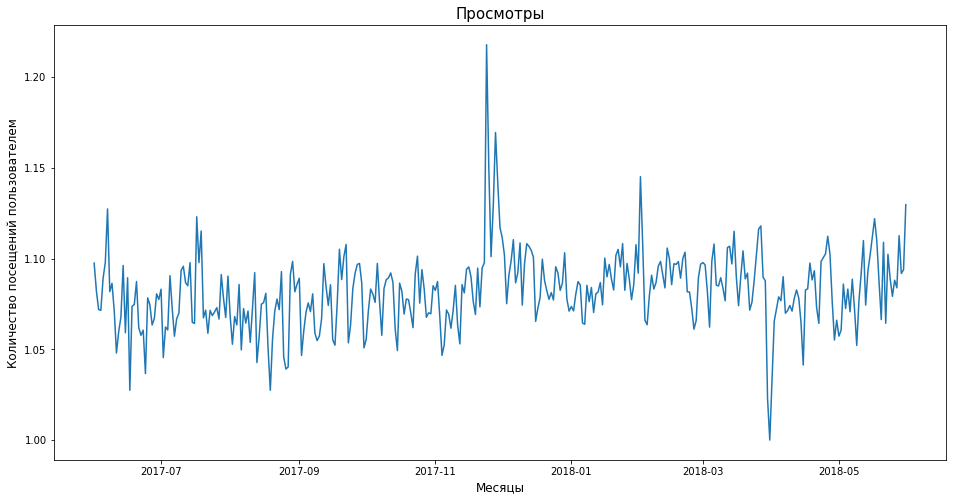

In [33]:
plt.figure(figsize = (16, 8))
sns.lineplot(x = sessions_per_user.index, y = sessions_per_user['sessions_per_user'], data = sessions_per_user)
plt.title('Просмотры', fontsize=15)
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('Количество посещений пользователем', fontsize=12)

#### Продолжительность типичной пользовательской сессии

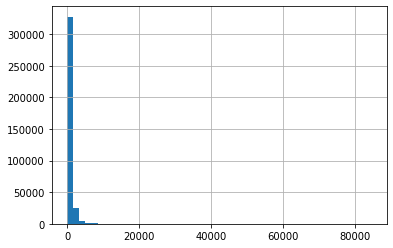

In [34]:
# рассчитаем длину сессии
visits['session_duration_sec'] = (
    visits['end_ts'] - visits['start_ts']
).dt.seconds
# посмотрим распределение
visits['session_duration_sec'].hist(bins=50) 

In [35]:
# судя по распределению, нам подходит мода для вычисления средней 
# продолжительности сессии
print(visits['session_duration_sec'].mode()) 

0    60
dtype: int64


Средняя пользовательская сессия продолжается минуту.

#### Retention Rate

In [36]:
# поменяем тип данных для даты сессии
visits['session_date'] = pd.to_datetime(visits['session_date'])

# сгруппируем визиты по уидам и самой первой дате сессии
first_activity_date = visits.groupby(['uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'

In [37]:
print(first_activity_date.head())

uid
11863502262781    2018-03-01
49537067089222    2018-02-06
297729379853735   2017-06-07
313578113262317   2017-09-18
325320750514679   2017-09-30
Name: first_activity_date, dtype: datetime64[ns]


In [38]:
# добавим дату первой сессии к визитам
visits = visits.merge(first_activity_date, on='uid')

# добавим первый месяц активности
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

# и создадим колонку с месяцем посещения
visits['activity_month'] = visits['session_date'].astype('datetime64[M]')

In [39]:
# рассчитем lifetime для когорты
visits['cohort_lifetime'] = (visits['activity_month'] - visits['first_activity_month'])
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [40]:
# сгруппируем когорты
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime("%Y-%m-%d")

In [41]:
# посчитаем изначальное число пользователей в когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_activity_month', 'uid']
]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [42]:
# рассчитаем коэффициент удержания
cohorts = cohorts.merge(initial_users_count,on='first_activity_month') 
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

In [43]:
# сгруппируем финальную таблицу
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)

retention_pivot = retention_pivot.drop(columns = 0)

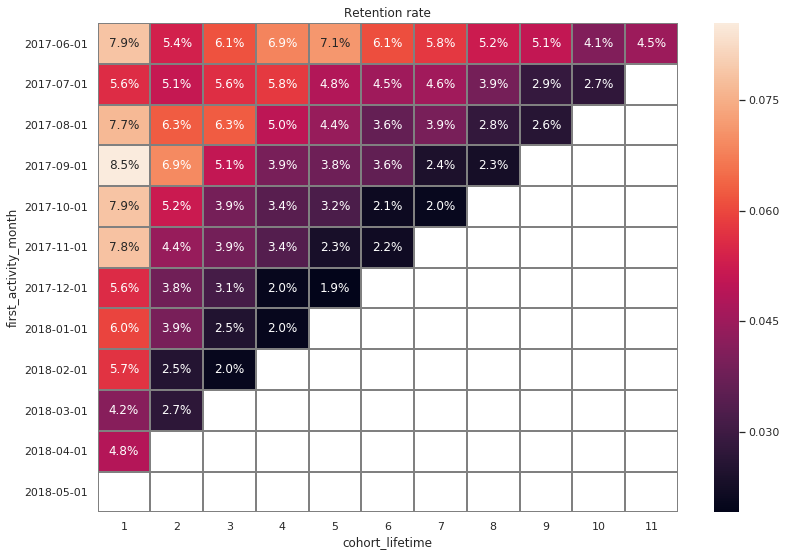

In [44]:
# выведем тепловую карту для retention rate
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

Retention rate на второй месяц составляет от 4,2 до 8,5%.

##### Вывод

Лучший RR у первой когорты - июньской. Даже у сентябрьской, которая на второй месяц жизни имела RR в 8,5%, к маю он упал до примерно двух процентов, как и у прочих, кроме июньской. Конечно, у апрельской когорты на последний зафиксированный месяц жизни 4,8 процентов, но это - всего второй месяц жизни, так что картина выглядит достаточно печально.

### Метрики электронной коммерции

#### Время с момента первого посещения сайта до совершения покупки.

In [45]:
# сгруппируем заказы по уидам и времени первой покупки
first_order_time = orders.groupby(['uid'])['buy_ts'].min().reset_index()

In [46]:
# найдем дату первой активности на сайте
first_activity_time = visits.groupby(['uid'])['start_ts'].min().reset_index()

In [47]:
# соединим таблички 1 и 2 по уидам
orders_time = first_order_time.merge(first_activity_time, on = 'uid')

In [48]:
# найдем время от первого посещения до первого заказа
orders_time['time_to_order'] = orders_time['buy_ts'] - orders_time['start_ts']

In [49]:
# переведем полученное значение в минуты 
orders_time['time_to_order'] = orders_time['time_to_order'].astype('timedelta64[m]')

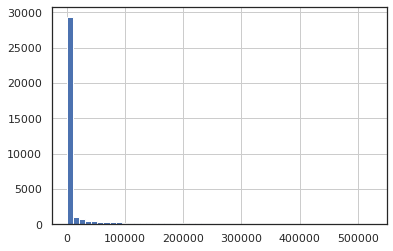

In [50]:
# отрисуем гистограмму
orders_time['time_to_order'].hist(bins=50) 

In [51]:
print(orders_time['time_to_order'].mean())

24340.175834405716


In [52]:
print(orders_time['time_to_order'].median())

16.0


In [53]:
print(orders_time['time_to_order'].mode())

0    1.0
dtype: float64


Учитывая гистограмму, для получения усредненных значений времени от посещения до покупки лучше использовать медиану (равна 16 минутам) или моду (равна минуте).

#### Среднее количество покупок на одного покупателя

In [54]:
# соединим заказы с первым днем активности
orders_all_time = orders.merge(first_activity_time, on = 'uid')

# укажем месяц регистрации пользователя
orders_all_time['reg_month'] = orders_all_time['start_ts'].astype(
    'datetime64[M]'
)

# время покупки используем для получения месяца покупки
orders_all_time['order_month'] = orders_all_time['buy_ts'].astype(
    'datetime64[M]'
)

# сгруппируем когорты
cohort_grouped = orders_all_time.groupby(['reg_month', 'order_month']).agg(
    {'uid': 'nunique', 'buy_ts' : 'nunique'}
)

In [55]:
# получим количество заказов для пользователя
cohort_grouped['orders_per_uid'] = cohort_grouped['buy_ts'] / cohort_grouped['uid']
cohort_grouped = cohort_grouped.reset_index()

# найдем lifetime когорты
cohort_grouped['cohort_lifetime'] = (
    cohort_grouped['order_month']
    - cohort_grouped['reg_month']
)
cohort_grouped['cohort_lifetime'] = cohort_grouped['cohort_lifetime'] / np.timedelta64(1, 'M')
cohort_grouped['cohort_lifetime'] = cohort_grouped['cohort_lifetime'].round().astype('int')
cohort_grouped['reg_month'] = cohort_grouped['reg_month'].dt.strftime("%Y-%m")

# сведем финальную таблицу
lifetime_pivot = cohort_grouped.pivot_table(
    index='reg_month',
    columns='cohort_lifetime',
    values='orders_per_uid',
    aggfunc='mean',
)

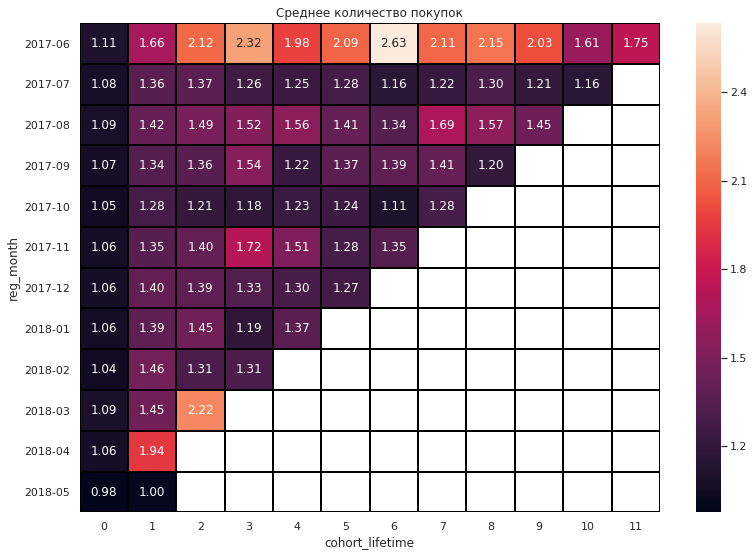

In [56]:
# отрисуем хитмап
plt.figure(figsize=(13, 9))
plt.title('Среднее количество покупок')
sns.heatmap(lifetime_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black')

In [57]:
cohort_grouped['orders_per_uid'].mean()

1.4173593126347876

Среднее количество покупок = 1,41

####  Средний чек с группировкой по времени совершения покупки

In [58]:
# для каждого месяца получим число покупок и сумму
average_cost = orders_all_time.groupby('order_month').agg({'uid': 'count', 'revenue' : 'sum'})

In [59]:
# найдем средний чек
average_cost['average_revenue'] = average_cost['revenue'] / average_cost['uid']

In [60]:
average_cost = average_cost.reset_index()

In [61]:
average_cost['order_month'] = average_cost['order_month'].dt.strftime("%Y-%m-%d")

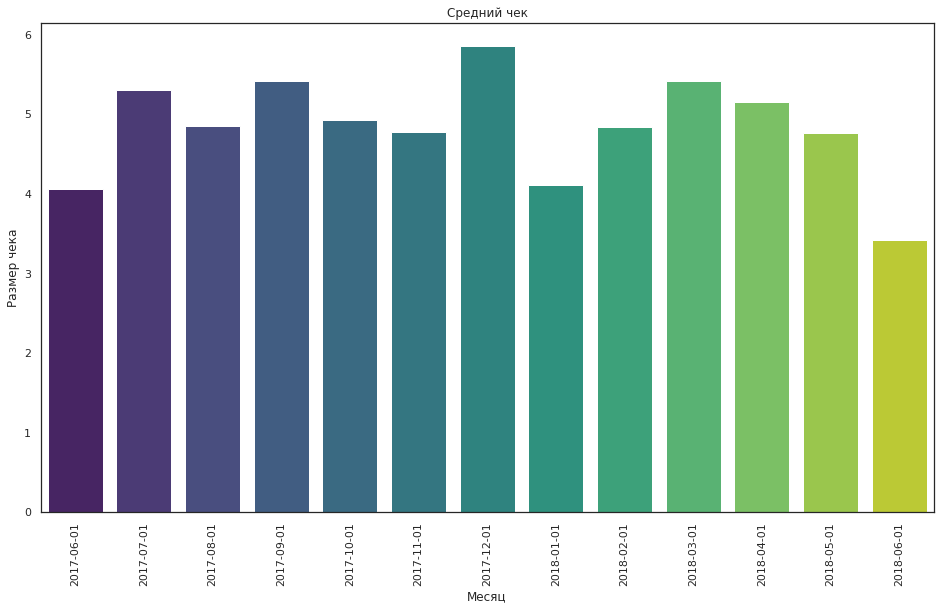

In [62]:
# отрисуем барплот со средним чеком по месяцам
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="order_month", y="average_revenue", data=average_cost, palette = 'viridis')
plt.title('Средний чек')
plt.xticks(rotation='vertical')
ax.set_xlabel('Месяц')
ax.set_ylabel('Размер чека')
plt.show()

#### LTV по когортам

In [63]:
orders_all_time.head()

,buy_ts,revenue,uid,start_ts,reg_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01,2017-06-01


In [64]:
orders_all_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 6 columns):
buy_ts         50415 non-null datetime64[ns]
revenue        50415 non-null float64
uid            50415 non-null uint64
start_ts       50415 non-null datetime64[ns]
reg_month      50415 non-null datetime64[ns]
order_month    50415 non-null datetime64[ns]
dtypes: datetime64[ns](4), float64(1), uint64(1)
memory usage: 2.7 MB


In [65]:
# найдем первый месяц покупки для каждого уида
first_orders = orders_all_time.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

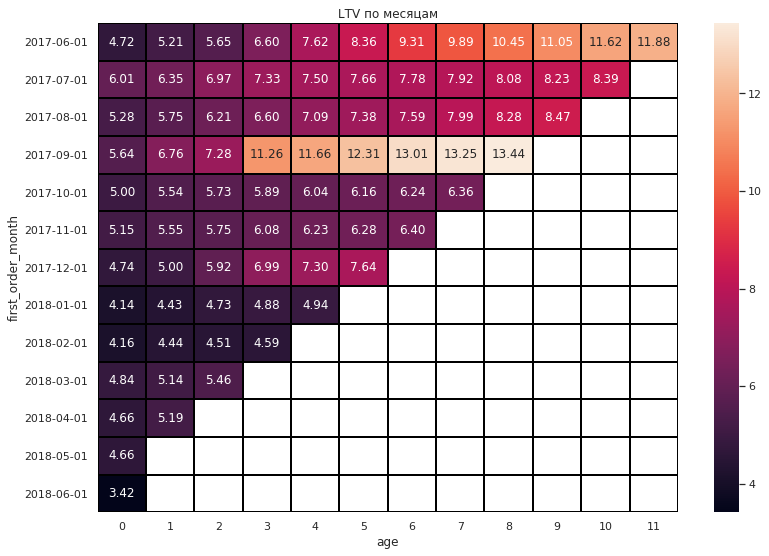

In [66]:
# вычислим размер когорты
cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']

# соединим таблицы с заказами и первым заказом по уидам
orders_new = pd.merge(orders_all_time, first_orders, on='uid')

# сгруппируем когорты
cohorts = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

# соединим когорты и их размер по месяцу первого заказа
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

# рассчитаем метрики при условии, что маржинальность = 100%
margin_rate = 1
report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

report['first_order_month'] = report['first_order_month'].dt.strftime("%Y-%m-%d")

# сведем финальную таблицу
output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
) 
output = output.cumsum(axis=1).round(2)

# отрисуем хитмап
plt.figure(figsize=(13, 9))
plt.title('LTV по месяцам')
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='black')

In [67]:
ltv_mean = output[5].mean()
ltv_mean

7.970000000000001

Средний LTV за 6 месяцев равен 7,97.

### Маркетинговые метрики

#### Затраты на маркетинг

In [68]:
# найдем общую сумму затрат на маркетинг
all_costs = costs['costs'].sum()
print(all_costs)

329131.62


Общая сумма расходов на маркетинг равна 329131,62.

In [69]:
costs['date'] = costs['dt'].dt.strftime("%Y-%m")

In [70]:
# посмотрим траты по источникам
source_grouped = costs.groupby('source_id')['costs'].sum()
print(source_grouped)

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64


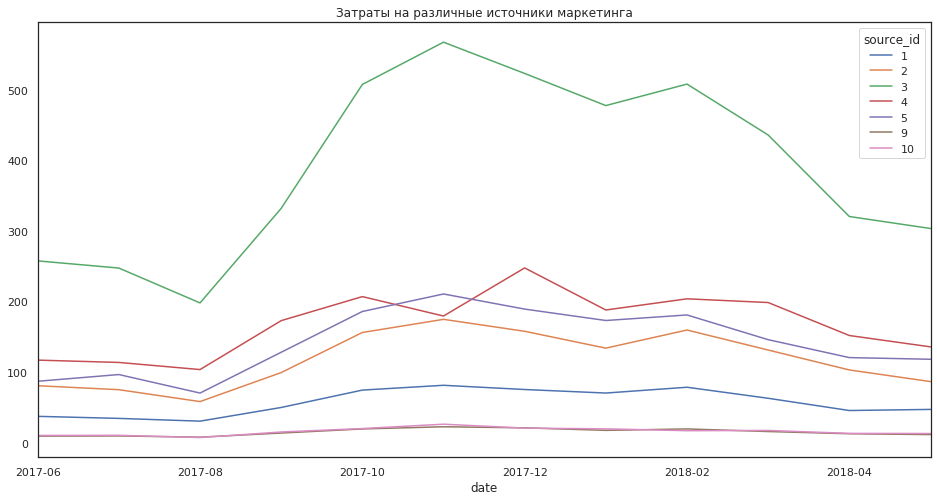

In [71]:
# сведем и отрисуем график затрат на разные источники по месяцам
source_grouped_on_time = costs.pivot_table(index='date', columns = 'source_id', values = 'costs')
source_grouped_on_time.plot(figsize = (16,8), title = 'Затраты на различные источники маркетинга')

Text(0, 0.5, 'Затраты')

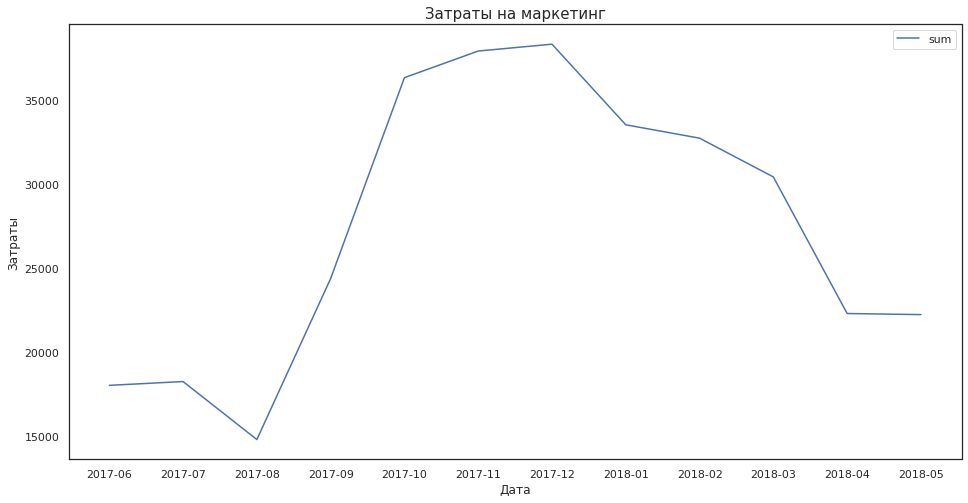

In [72]:
# посмотрим на общие затраты по месяцам на маркетинг
source_grouped_on_time = costs.pivot_table(index = 'date', values = 'costs', aggfunc=['sum'])
plt.figure(figsize = (16, 8))
sns.lineplot(data = source_grouped_on_time)
plt.title('Затраты на маркетинг', fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Затраты', fontsize=12)

#### CAC на одного покупателя и для каждого источника трафика.

In [73]:
# сделаем срез данных по первому посещению
sourse_of_visits = visits.query('session_date == first_activity_date')
# соединим таблички по уиду и сгруппируем по источнику
customers_by_source = (orders.merge(sourse_of_visits, on = 'uid', how = 'inner')).groupby('source_id').agg({'uid':'nunique'}).reset_index()

In [74]:
# сджойним полученную таблицу со сгруппированными источниками
cac_per_cource = customers_by_source.join(source_grouped, on = 'source_id')

In [75]:
cac_per_cource

,source_id,uid,costs
0,1,4044,20833.27
1,2,3893,42806.04
2,3,10712,141321.63
3,4,10546,61073.60
4,5,7688,51757.10
5,7,1,NaN
6,9,1106,5517.49
7,10,1370,5822.49


In [76]:
# найдем cac для каждого источника
cac_per_cource = cac_per_cource.fillna(0)
cac_per_cource['cac'] = cac_per_cource['costs'] / cac_per_cource['uid']
cac_per_cource.sort_values('cac', ascending = False)

,source_id,uid,costs,cac
2,3,10712,141321.63,13.192833
1,2,3893,42806.04,10.995643
4,5,7688,51757.10,6.732193
3,4,10546,61073.60,5.791163
0,1,4044,20833.27,5.151649
6,9,1106,5517.49,4.988689
7,10,1370,5822.49,4.249993
5,7,1,0.00,0.000000


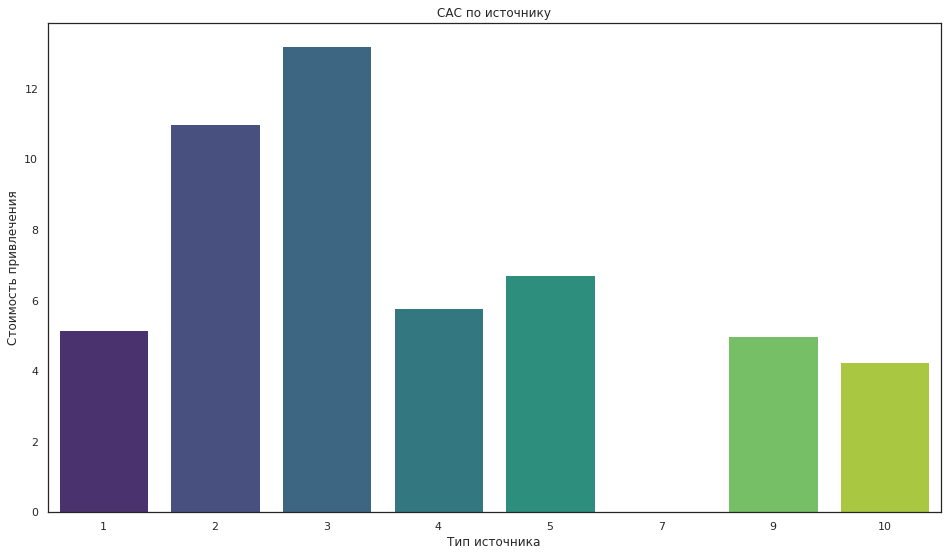

In [77]:
# отрисуем барплот
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="source_id", y="cac", data=cac_per_cource, palette = 'viridis')
plt.title('CAC по источнику')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Стоимость привлечения')
plt.show()

In [78]:
# посчитаем затраты на одного покупателя
# cac = cac_per_cource['costs'].sum() / cac_per_cource['uid'].sum()
print(f'Средний САС по проекту: {costs["costs"].sum() / orders["uid"].nunique():.2f}')

Средний САС по проекту: 9.01


In [79]:
print(f'Средний САС по проекту: {costs["costs"].sum() / orders["uid"].nunique():.2f}')

Средний САС по проекту: 9.01


#### Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Постройте графики, отражающие изменения метрик во времени.

In [80]:
# первый источник для юзера по табличке visits

visit_source = visits.sort_values(by='start_ts').groupby(['uid'], as_index=False).agg({'source_id' : 'first'})

# присоединяем по юзеру его к табличке с ордерами

orders = orders.merge(visit_source, on='uid', how='inner')

In [81]:
first_order_month = orders.groupby('uid')['buy_ts'].min()
first_order_month.name = 'first_order_month'
orders = orders.join(first_order_month, on='uid')
orders['first_order_month'] = orders['first_order_month'].astype('datetime64[M]')
orders['buy_ts'] = orders['buy_ts'].astype('datetime64[M]')

In [82]:
# группируем табличку ордерс по месяцу первой покупки + источнику, находим кол-во людей в когортах
cohort_size = orders.groupby(['first_order_month', 'source_id']).agg({'uid' : 'nunique'}).reset_index()

In [83]:
# группируем табличку ордерс по месяцу первой покупки, текущему месяцу,  источнику, суммируем revenue
revenue_sum = orders.groupby(['first_order_month', 'buy_ts', 'source_id']).agg({'revenue' : 'sum'}).reset_index()

In [84]:
# объединяем по месяцу первой покупки и источнику таблички 3/4
report = pd.merge(revenue_sum, cohort_size, on = ['first_order_month', 'source_id'])

In [85]:
# Находим LTV
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['buy_ts'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['uid']
report['ltv'] = report['gp'] / report['uid']

In [86]:
# Косты группируем по источнику+месяцу
costs['dt'] =  costs['dt'].astype('datetime64[M]')
costs = costs.groupby(['dt', 'source_id']).agg({'costs' : 'sum'}).reset_index()
costs.columns = ['first_order_month', 'source_id', 'costs']

In [87]:
# Джойним их на табличку с LTV по источнику+месяцу
romi = pd.merge(costs, report, on = ['first_order_month', 'source_id'])

In [88]:
# Косты делим на кол-во покупателей и получаем CAC
romi['cac'] = romi['costs'] / romi['uid']

In [89]:
# Делим LTV на CAC и получаем ROMI
romi['romi'] = romi['ltv'] / romi['cac']

In [90]:
romi

,first_order_month,source_id,costs,buy_ts,revenue,uid,gp,age,ltv,cac,romi
0,2017-06-01,1,1125.61,2017-06-01,1378.70,190,1378.70,0,7.256316,5.924263,1.224847
1,2017-06-01,1,1125.61,2017-07-01,414.98,190,414.98,1,2.184105,5.924263,0.368671
2,2017-06-01,1,1125.61,2017-08-01,419.43,190,419.43,2,2.207526,5.924263,0.372625
3,2017-06-01,1,1125.61,2017-09-01,714.24,190,714.24,3,3.759158,5.924263,0.634536
4,2017-06-01,1,1125.61,2017-10-01,811.20,190,811.20,4,4.269474,5.924263,0.720676
...,...,...,...,...,...,...,...,...,...,...,...
509,2018-05-01,3,9411.42,2018-05-01,3256.54,844,3256.54,0,3.858460,11.150972,0.346020
510,2018-05-01,4,4214.21,2018-05-01,3802.91,804,3802.91,0,4.729988,5.241555,0.902402
511,2018-05-01,5,3669.56,2018-05-01,2094.04,497,2094.04,0,4.213360,7.383421,0.570652
512,2018-05-01,9,362.17,2018-05-01,223.05,60,223.05,0,3.717500,6.036167,0.615871


In [91]:
sources_list = [1, 2, 3, 4, 5, 9, 10]

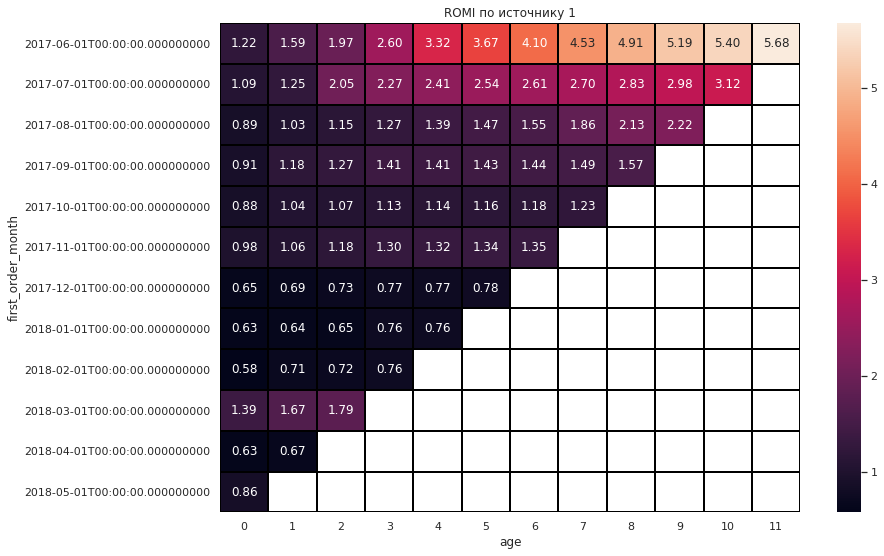

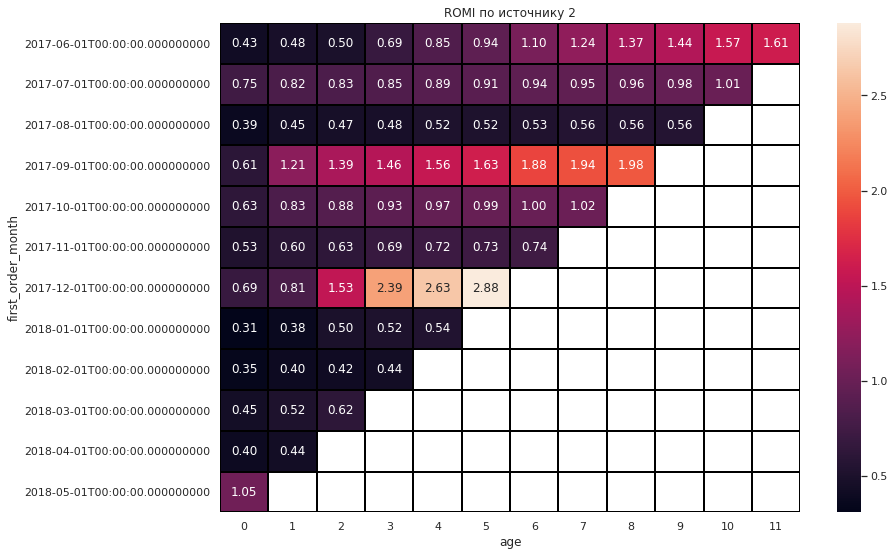

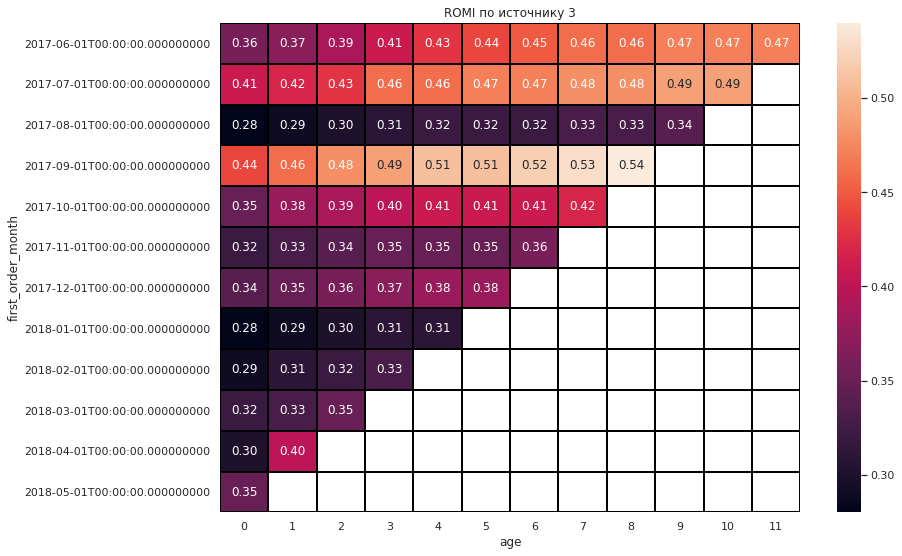

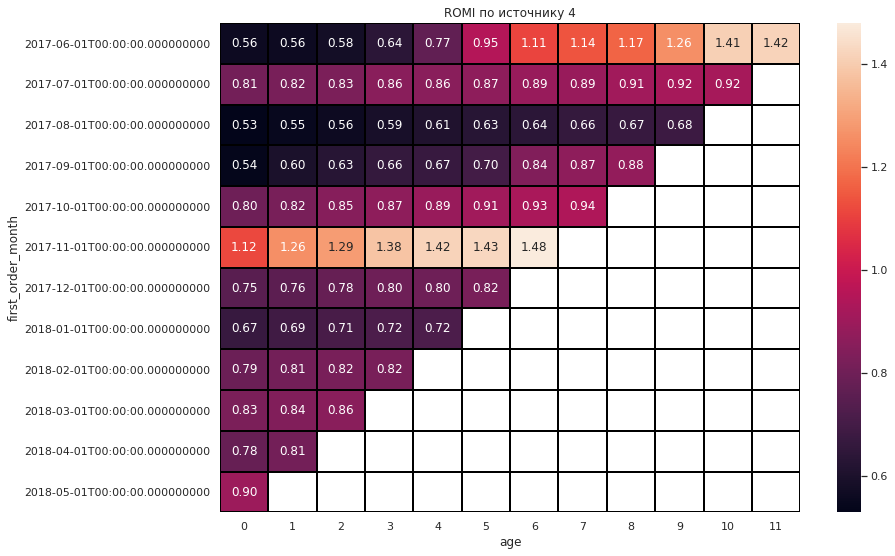

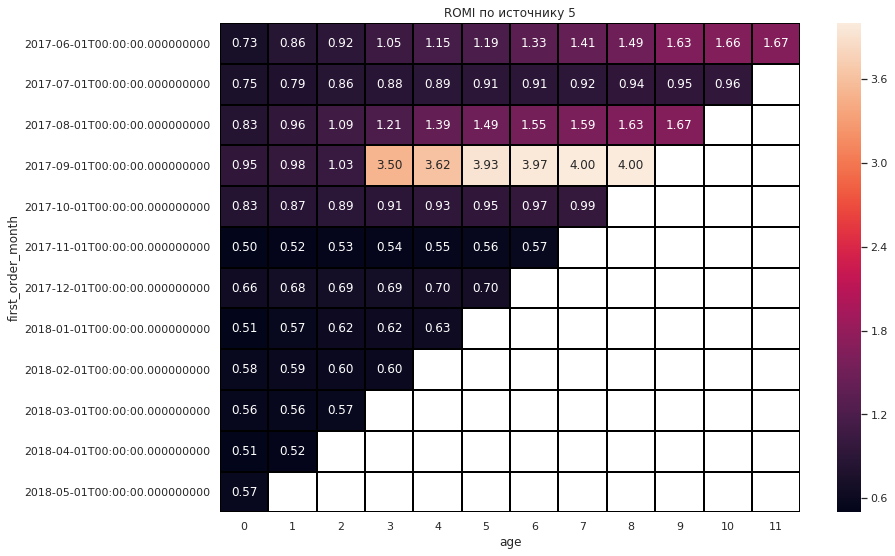

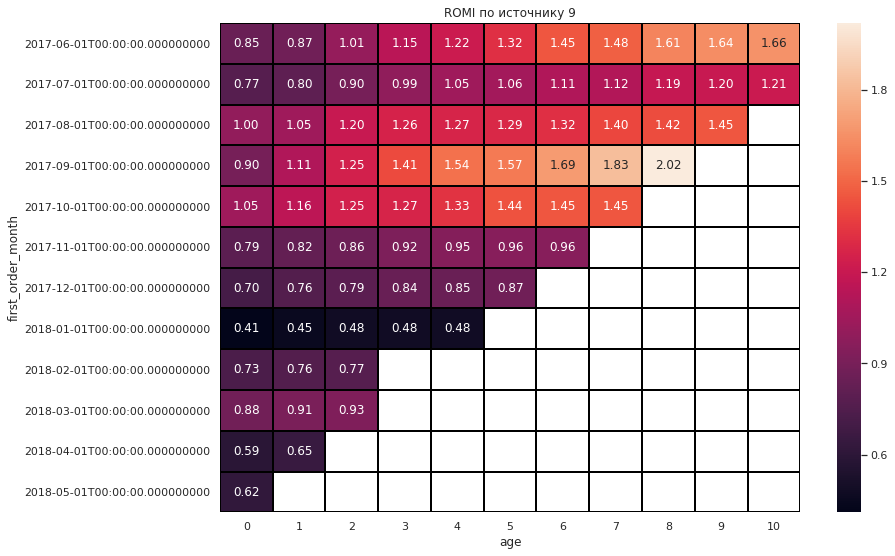

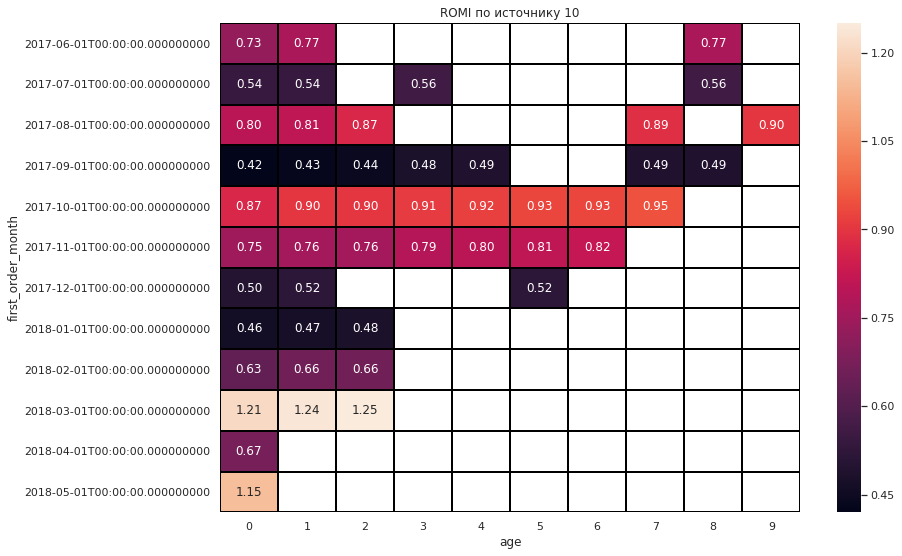

In [92]:
for value in sources_list:
    romi1 = romi.query("source_id == @value")
    output = romi1.pivot_table(
            index=['first_order_month'], columns='age', values='romi', aggfunc='mean'
    )
    output = output.cumsum(axis=1).round(2)
    
    plt.figure(figsize=(13, 9))
    plt.title(f'ROMI по источнику {value}')
    sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='black')

In [93]:
f_s = visits.sort_values(by='start_ts').groupby(['uid'], as_index=False).agg({'source_id' : 'first'})
orders.merge(f_s.rename(columns={'source_id': 's'}), on='uid', how='inner')\
    .assign(is_equal=lambda row: row['source_id'] == row['s'])['is_equal'].value_counts(normalize=True)

True    1.0
Name: is_equal, dtype: float64

## Выводы и рекомендации

###  Источники трафика, на которые маркетологам стоит делать упор.

Источники трафика, приносящие больше дохода — под номерами 1 и 2, при этом они даже не самые дорогостоящие. Стоит обраттмть внимание на другие источники ради их пересмотра, отмены или доработки, особенно 3й - в него вложена 141 тысяча у.е (больше всего), а его romi выглядит удручающе.

### Выводы после подсчёта метрик каждого вида.

Посещаемость сайта достаточно стабильна, люди возвращаются, покупки делать удобно — многие справляются за минуту. 

### Итоги когортного анализа.

Лучшие результаты у когорты с источником 1, у июньской и сентябрьской когорт. Второй источник тоже неплох, но другие отстают. Необходимо провести дополнительный сравнительный анализ с упором на тонкости этих источников, а также уточнить суть колебаний в летний период — связан ли он с отпусками, или были внесены определенные изменения в сайт, которые повлияли на результат.